# Titanic Challenge

First import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Then we load our dataframe

In [2]:
df = pd.read_csv("data/train.csv")
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [3]:
# Drop the columns "Name", "Ticket" and "Cabin"
df2 = df.drop("Name",axis = 1).drop("Ticket",axis = 1).drop("Cabin",axis = 1).drop("PassengerId",axis = 1)
print(df2.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


In [4]:
# Imput Integer number "male":0 and "female":1
df2["Sex"] = df2["Sex"].replace(["male"], 0)
df2["Sex"] = df2["Sex"].replace(["female"], 1)
# Trtansform Embarked in three dummy variables: Embarked_C  Embarked_Q  Embarked_S 
df3 = pd.get_dummies(df2)

print(df3.head())


   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0         0       3    0  22.0      1      0   7.2500           0           0   
1         1       1    1  38.0      1      0  71.2833           1           0   
2         1       3    1  26.0      0      0   7.9250           0           0   
3         1       1    1  35.0      1      0  53.1000           0           0   
4         0       3    0  35.0      0      0   8.0500           0           0   

   Embarked_S  
0           1  
1           0  
2           1  
3           1  
4           1  


Imputation


In [5]:
from sklearn.preprocessing import Imputer

X = df3.drop("Survived",axis = 1).values
y = df3["Survived"].values

imp = Imputer(missing_values = "NaN", 
             strategy = "mean",
             axis = 0) # axis = 0 correspond to the comlumns
imp.fit(X)

X = imp.transform(X)

print(X.shape)




(891, 9)


In [6]:
# Insert column normalization
from sklearn.preprocessing import scale
X = scale(X)





In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

print(X_train.shape)


(712, 9)


# 1 Logistic model no cross validation



('one_hot', <tf.Tensor 'one_hot_19:0' shape=(?, 1, 2) dtype=float32>)
('reshape', <tf.Tensor 'Reshape_73:0' shape=(?, 2) dtype=float32>)
Step:     0	Loss: 2.197	Acc: 34.97%
Step:   400	Loss: 0.534	Acc: 75.28%
Step:   800	Loss: 0.452	Acc: 79.35%
Step:  1200	Loss: 0.441	Acc: 80.48%
Step:  1600	Loss: 0.438	Acc: 79.92%
Step:  2000	Loss: 0.437	Acc: 79.63%
Step:  2400	Loss: 0.437	Acc: 79.92%
Step:  2800	Loss: 0.437	Acc: 79.92%


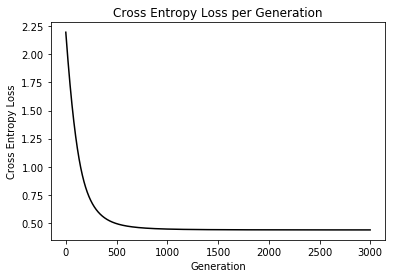

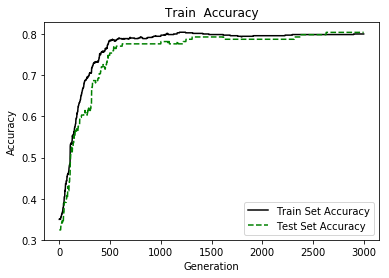

In [28]:
import tensorflow as tf

# Define Graph

nb_classes = 2  # 0 ~ 1

# Create the feature 
x_tf_train = tf.placeholder(shape=[None, 9], dtype=tf.float32)
y_tf_train = tf.placeholder(shape=[None, 1], dtype=tf.int32)

Y_one_hot = tf.one_hot(y_tf_train, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)


# Create a Weight tensor W and the bias tensor b
W = tf.Variable(tf.random_normal([9, nb_classes]), name='weight')
b = tf.Variable(tf.random_normal([nb_classes]), name='bias')

# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
logits = tf.matmul(x_tf_train, W) + b
hypothesis = tf.nn.softmax(logits)

cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                 labels=Y_one_hot)

loss = tf.reduce_mean(cost_i)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


#Train Model
loss_vec = []
acc_vec_train = []
acc_vec_test = []
with tf.Session() as sess:
    # Initialize variables
    init = tf.global_variables_initializer()
    sess.run(init)
    losses = []
    for i in range(3000):
        # Fix the dimension of y_train
        y_train_t = np.transpose([y_train])
        # Run the session, this is actually what fits the model
        sess.run(optimizer, feed_dict={x_tf_train: X_train, y_tf_train: y_train_t})
        
        temp_loss, acc_train = sess.run([loss, accuracy], feed_dict={
                                 x_tf_train: X_train, y_tf_train: y_train_t})
        acc_test = sess.run(accuracy, feed_dict={
                                 x_tf_train: X_test, y_tf_train: np.transpose([y_test])})
        loss_vec.append(temp_loss)
        
        acc_vec_train.append(acc_train)
        acc_vec_test.append(acc_test)
        if i % 400 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                i, temp_loss, acc_train))
        
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(acc_vec_train, 'k-', label='Train Set Accuracy')
plt.plot(acc_vec_test, 'g--', label='Test Set Accuracy')
#plt.plot(acc_vec, 'k-')
plt.title('Train  Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# 2 Logistic model no cross validation stochastic gradient descend

('one_hot', <tf.Tensor 'one_hot_20:0' shape=(?, 1, 2) dtype=float32>)
('reshape', <tf.Tensor 'Reshape_77:0' shape=(?, 2) dtype=float32>)
Step:     0	Loss: 1.165	Acc: 72.00%
Step:   400	Loss: 0.522	Acc: 80.00%
Step:   800	Loss: 0.407	Acc: 86.00%
Step:  1200	Loss: 0.567	Acc: 68.00%
Step:  1600	Loss: 0.573	Acc: 74.00%
Step:  2000	Loss: 0.645	Acc: 70.00%
Step:  2400	Loss: 0.521	Acc: 72.00%
Step:  2800	Loss: 0.359	Acc: 82.00%


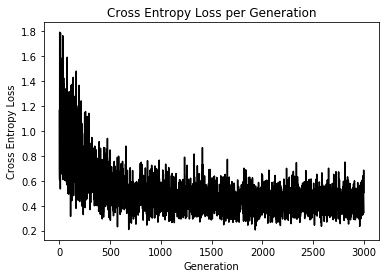

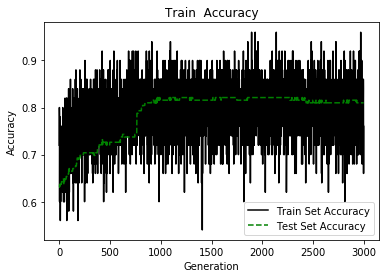

In [29]:
import tensorflow as tf

# Define Graph

nb_classes = 2  # 0 ~ 1

# Create the feature 
x_tf_train = tf.placeholder(shape=[None, 9], dtype=tf.float32)
y_tf_train = tf.placeholder(shape=[None, 1], dtype=tf.int32)

Y_one_hot = tf.one_hot(y_tf_train, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)


# Create a Weight tensor W and the bias tensor b
W = tf.Variable(tf.random_normal([9, nb_classes]), name='weight')
b = tf.Variable(tf.random_normal([nb_classes]), name='bias')

# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
logits = tf.matmul(x_tf_train, W) + b
hypothesis = tf.nn.softmax(logits)

cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                 labels=Y_one_hot)

loss = tf.reduce_mean(cost_i)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

batch_size = 50

#Train Model
loss_vec = []
acc_vec_train = []
acc_vec_test = []
with tf.Session() as sess:
    # Initialize variables
    init = tf.global_variables_initializer()
    sess.run(init)
    losses = []
    for i in range(3000):
        rand_index = np.random.choice(len(X_train), size=batch_size)
        x_batch = X_train[rand_index]
        y_batch = np.transpose([y_train[rand_index]])
        # Run the session, this is actually what fits the model
        sess.run(optimizer, feed_dict={x_tf_train: x_batch, y_tf_train: y_batch})
        
        temp_loss, acc_train = sess.run([loss, accuracy], feed_dict={
                                 x_tf_train: x_batch, y_tf_train: y_batch})
        acc_test = sess.run(accuracy, feed_dict={
                                 x_tf_train: X_test, y_tf_train: np.transpose([y_test])})
        
        loss_vec.append(temp_loss)
      
        acc_vec_train.append(acc_train)
        acc_vec_test.append(acc_test)
        if i % 400 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                i, temp_loss, acc_train))
        
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(acc_vec_train, 'k-', label='Train Set Accuracy')
plt.plot(acc_vec_test, 'g--', label='Test Set Accuracy')
#plt.plot(acc_vec, 'k-')
plt.title('Train  Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# 3 Neural Network  one layer

('one_hot', <tf.Tensor 'one_hot_21:0' shape=(?, 1, 2) dtype=float32>)
('reshape', <tf.Tensor 'Reshape_81:0' shape=(?, 2) dtype=float32>)
Step:     0	Loss: 10.231	Acc: 65.57%
Step:   400	Loss: 0.621	Acc: 82.57%
Step:   800	Loss: 0.426	Acc: 86.14%
Step:  1200	Loss: 0.305	Acc: 89.00%
Step:  1600	Loss: 0.294	Acc: 86.43%
Step:  2000	Loss: 0.262	Acc: 89.43%
Step:  2400	Loss: 0.208	Acc: 90.14%
Step:  2800	Loss: 0.200	Acc: 92.14%


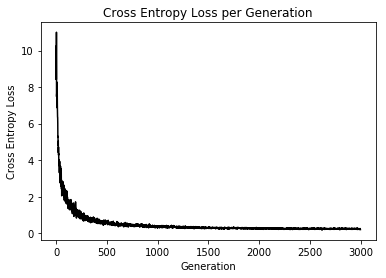

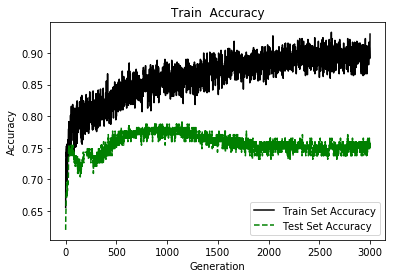

In [30]:
import tensorflow as tf

# Define Graph

nb_classes = 2  # 0 ~ 1

# Create the feature 
x_tf_train = tf.placeholder(shape=[None, 9], dtype=tf.float32)
y_tf_train = tf.placeholder(shape=[None, 1], dtype=tf.int32)

Y_one_hot = tf.one_hot(y_tf_train, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)


# Create a Weight tensor W and the bias tensor b
hidden_layer_nodes = 300
W1 = tf.Variable(tf.random_normal(shape=[9,hidden_layer_nodes])) # inputs -> hidden nodes
b1 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes]))   # one biases for each hidden node
W2 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes,nb_classes])) # hidden inputs -> 1 output
b2 = tf.Variable(tf.random_normal(shape=[nb_classes]))   # 1 bias for the output

# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
# Declare model operations
logits_hidden = tf.matmul(x_tf_train, W1) + b1
hidden_output = tf.nn.relu(logits_hidden)
logits_output = tf.matmul(hidden_output, W2) + b2
hypothesis     = tf.nn.softmax(logits_output)

cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=logits_output,
                                                 labels=Y_one_hot)

loss = tf.reduce_mean(cost_i)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)



prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

batch_size = 700

#Train Model
loss_vec = []
acc_vec_train = []
acc_vec_test = []
with tf.Session() as sess:
    # Initialize variables
    init = tf.global_variables_initializer()
    sess.run(init)
    losses = []
    for i in range(3000):
        rand_index = np.random.choice(len(X_train), size=batch_size)
        x_batch = X_train[rand_index]
        y_batch = np.transpose([y_train[rand_index]])
        
        # Run the session, this is actually what fits the model
        sess.run(optimizer, feed_dict={x_tf_train: x_batch, y_tf_train: y_batch})
        
        temp_loss, acc_train = sess.run([loss, accuracy], feed_dict={
                                 x_tf_train: x_batch, y_tf_train: y_batch})
    
        acc_test = sess.run(accuracy, feed_dict={
                                x_tf_train: X_test, y_tf_train: np.transpose([y_test])})
        
        loss_vec.append(temp_loss)
        acc_vec_train.append(acc_train)
        acc_vec_test.append(acc_test)
        if i % 400 == 0:
           print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                i, temp_loss, acc_train))
        
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(acc_vec_train, 'k-', label='Train Set Accuracy')
plt.plot(acc_vec_test, 'g--', label='Test Set Accuracy')
#plt.plot(acc_vec, 'k-')
plt.title('Train  Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

#  Logistic model with sigmoid_cross_entropy_with_logits no cross val

In [ ]:

import tensorflow as tf

# Define Graph

# Create the feature 
x_tf_train = tf.placeholder(shape=[None, 9], dtype=tf.float32)
y_tf_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)

#x_tf_train = tf.placeholder(shape=[891, 9], dtype=tf.float32)
#y_tf_train = tf.placeholder(shape=[891, 1], dtype=tf.float32)

# Create a Weight tensor W and the bias tensor b
W = tf.Variable(tf.random_normal(shape=[9,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
    
# Declare model operations
model = tf.add(tf.matmul(x_tf_train, W), b)
    
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model, labels=y_tf_train))
# see tf.nn.sigmoid() vs    tf.nn.sigmoid_cross_entropy_with_logits()

# Declare optimizer
opt = tf.train.GradientDescentOptimizer(0.01)
train_step = opt.minimize(loss)

#Train Model

with tf.Session() as sess:
    # Initialize variables
    init = tf.global_variables_initializer()
    sess.run(init)

    loss_vec = []
    for i in range(1000):
        # Fix the dimension of y_train
        y_train_t = np.transpose([y_train])
        # Run the session, this is actually what fits the model
        sess.run(train_step, feed_dict={x_tf_train: X_train, y_tf_train: y_train_t})
        # Compute the loss function for storing in tem_loss for later ploting
        temp_loss = sess.run(loss, feed_dict={x_tf_train: X_train, y_tf_train: y_train_t})
        loss_vec.append(temp_loss)
        



